In [52]:
# Coinbase Trend Analysis

import os

import cbpro

import json, hmac, hashlib, time, requests, base64
from requests.auth import AuthBase

import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

# get list of products

data = pd.read_csv('products.csv')

data = data.loc[data['quote_currency'].isin(['USD', 'USDC'])]

data = data.loc[data['max_market_funds']>=250000]

data.to_csv('products_to_screen.csv')

'''
# Refresh product list:

# Define Public Client
public_client = cbpro.PublicClient()

# Get Products
products = pd.DataFrame(public_client.get_products())

products.sort_values('base_currency')

print(products[:10])

products.to_csv('products.csv')
'''

data.head()

<bound method NDFrame.head of      Unnamed: 0        id base_currency quote_currency  base_min_size  \
2             2  AAVE-USD          AAVE            USD          0.010   
4             4   LTC-USD           LTC            USD          0.100   
26           26  BTC-USDC           BTC           USDC          0.001   
36           36   GRT-USD           GRT            USD         10.000   
59           59  ETH-USDC           ETH           USDC          0.010   
63           63  ZEC-USDC           ZEC           USDC          0.010   
64           64   ETH-EUR           ETH            EUR          0.010   
65           65   LTC-EUR           LTC            EUR          0.100   
70           70   LTC-GBP           LTC            GBP          0.100   
81           81   BTC-USD           BTC            USD          0.001   
95           95   BCH-USD           BCH            USD          0.010   
97           97   ETH-GBP           ETH            GBP          0.010   
98           98   BCH

In [54]:
# Get Historic Rates
# the max number of data points for a single request is 300 candles
# if start/end time and granularity results in more than 300 data points,
# the request will be rejected.
# Make multiple requests if fine granularity results in > 300 data points.

# Requesting data can take up to several minutes to complete execution.

import cbpro
import json, hmac, hashlib, time, requests, base64
from requests.auth import AuthBase
import pandas as pd
import time

# Define Public Client
public_client = cbpro.PublicClient()

# Define ticker symbols to retrieve
symbols = data['id'].values

# Known issue: start and end dates results in error
# Default returns 300 data points at specified granularity
# Optional parameters: start and end dates need to be in ISO 8601 format (YYYYMMDD)
#start = 20201215
#end = 20201231

# granularity is the time between ticks and must be one of these values:
# {60, 300, 900, 3600, 21600, 86400} which corresponds to
# one minute (60 sec), five minutes (300 sec), fifteen minutes (900 sec),
# one hour (3600 sec), six hours (21600 sec), and one day (86400 sec)

granularity = 86400

# Coinbase requests are rate limited to 3 - 6 requests per second
# https://docs.pro.coinbase.com/#rate-limits

# Data Columns: 0:'time', 1:'low', 2:'high', 3:'open', 4:'close', 5:'volume'

for symbol in symbols:
    try:
        temp = pd.DataFrame(public_client.get_product_historic_rates(symbol, granularity=granularity))
        temp.rename(columns={4:symbol}, inplace=True)
    except: print("Request Error")

    try:
        tick_data.loc[:, symbol] = temp.iloc[:, 4]
    except:
        tick_data = pd.DataFrame(temp.iloc[:, 4]) 
        
    time.sleep(0.4) # delay > 0.333 sec or 3 requests per sec (1 second/3 requests = .333 seconds/request)

tick_data.to_csv('daily.csv')

In [62]:
# work with saved historic data to minimize the number of api requests

import pandas as pd
import numpy as np
from pylab import mpl, plt

tick_data = pd.read_csv('daily.csv', index_col=0)

tick_data.iloc[:, 0] = pd.to_datetime(tick_data.iloc[:, 0], infer_datetime_format=True, unit='s')

tick_data.set_index('0', inplace=True)

tick_data.sort_values(by='0', inplace=True)

tick_data.head

<bound method NDFrame.head of             GRT-GBP  DAI-USD  BAL-BTC  AAVE-USD  SNX-EUR  LTC-USD  XTZ-EUR  \
0                                                                            
2020-12-17   0.0927   0.0927   0.0927    85.174   0.0927   101.17   0.0927   
2020-12-18   0.1947   0.1947   0.1947    90.999   0.1947   109.46   0.1947   
2020-12-19   0.3555   0.3555   0.3555    88.767   0.3555   120.02   0.3555   
2020-12-20   0.5558   0.5558   0.5558    85.460   0.5558   114.65   0.5558   
2020-12-21   0.3508   0.3508   0.3508    80.820   0.3508   104.44   0.3508   
2020-12-22   0.4081   0.4081   0.4081    84.357   0.4081   114.31   0.4081   
2020-12-23   0.3011   0.3011   0.3011    75.608   0.3011   102.35   0.3011   
2020-12-24   0.3035   0.3035   0.3035    80.633   0.3035   111.20   0.3035   
2020-12-25   0.2648   0.2648   0.2648    79.771   0.2648   127.67   0.2648   
2020-12-26   0.3586   0.3586   0.3586    75.033   0.3586   129.56   0.3586   
2020-12-27   0.2940   0.2940   0.2

<AxesSubplot:xlabel='0'>

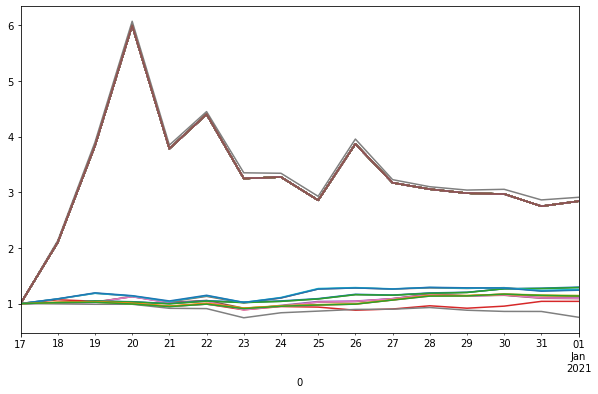

In [94]:
# Normalize Price Data

import pandas as pd
import numpy as np
from pylab import mpl, plt

returns = pd.DataFrame(tick_data/tick_data.iloc[0,:])

returns.plot(figsize=(10,6), legend = False)

<AxesSubplot:>

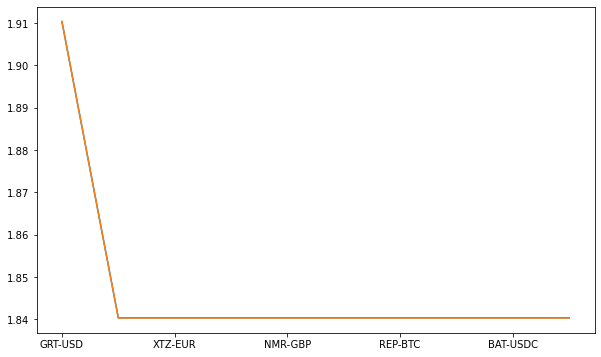

In [84]:
momentum['momentum'] = pd.DataFrame((returns.iloc[-1]-returns.iloc[0]).round(4))
momentum = momentum.sort_values(by='momentum', ascending=False)
momentum[:10].plot(figsize=(10,6), legend=False)

In [85]:
returns.to_csv('returns.csv')
momentum.to_csv('momentum.csv')